In [1]:
import requests
from datetime import datetime
import pandas as pd
import re
import time
from bs4 import BeautifulSoup
import os
from tqdm import tqdm
import itertools
from pathlib import Path
import seaborn as sns
from matplotlib import pyplot as plt
import yaml
import ast
import glob
import numpy as np
import psycopg2
from psycopg2.extensions import register_adapter, AsIs
psycopg2.extensions.register_adapter(np.int32, psycopg2._psycopg.AsIs)
psycopg2.extensions.register_adapter(np.int64, psycopg2._psycopg.AsIs)

In [2]:
# Время ожидания между запросами, в сек.
wait = 0.3

# Функции подключения к PostgreSQL.
param_dic = {
    'host'      : '192.168.200.12',
    'database'  : 'hh_pet',
    'user'      : 'hh_user',
    'password'  : 'DWuh1289h12ej2h32178dh2-38hD'
}

def connect(params_dic):
    """ Connect to the PostgreSQL database server """
    conn = None
    try:
        # connect to the PostgreSQL server
        conn = psycopg2.connect(**params_dic)
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    print("Connection successful")
    return conn

def execute_mogrify_insert(conn, df, table):
    """
    Using cursor.mogrify() to build the bulk insert query
    then cursor.execute() to execute the query
    """
    # Create a list of tupples from the dataframe values
    tuples = [tuple(x) for x in df.to_numpy()]
    # Comma-separated dataframe columns
    cols = ','.join(list(df.columns))
    # SQL quert to execute
    cursor = conn.cursor()
    
    col = ''
    for i in range(0, len(df.columns)):
        col += '%s,'
    values = [cursor.mogrify("(" + col[:-1] + ")", tup).decode('utf8') for tup in tuples]
    query  = "INSERT INTO %s(%s) VALUES " % (table, cols) + ",".join(values)
    
    try:
        cursor.execute(query, tuples)
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    print("execute_mogrify() done")
    cursor.close()

def execute_mogrify_search_vacancy(vacancy_id, conn):
    """
    Поиск вакансии в БД по id.
    """
    cursor = conn.cursor()
    query = "SELECT COUNT(*) FROM vacancies WHERE vacancy_id='" + str(vacancy_id) + "'"
    try:
        cursor.execute(query)
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    
    result = cursor.fetchone()[0]
    cursor.close()
    
    if result > 0:
        return 'update'
    else:
        return 'insert'
    
def execute_mogrify_update_vacancy(x, conn):
    """
    Обновление поля published_at вакансии.
    """
    vacancy_id = x[0]
    published_at = x[1]
    
    cursor = conn.cursor()
    query = "UPDATE vacancies SET published_at='" + str(published_at) + "' WHERE vacancy_id='" + str(vacancy_id) + "'"
    try:
        cursor.execute(query)
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    
    cursor.close()
    return 0
    
def execute_mogrify_load_professions(conn):
    """
    Загрузка профессий из БД.
    """
    cursor = conn.cursor()
    query = "SELECT profession_id, query FROM professions"
    try:
        cursor.execute(query)
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    
    tuples = cursor.fetchall()
    cols = ['profession_id', 'query']
    cursor.close()
    return pd.DataFrame(tuples,columns=cols)

In [3]:
def get_vacancies(date_from=None):
    """
    Функция получает список вакансий на hh.ru через API.
    """
    url = 'https://api.hh.ru/vacancies'
    
    start = datetime.now()
    timer = 10
    
    # Получаем данные по профессиям и ключевым словам для поиска.
    conn = connect(param_dic)
    df_prof = execute_mogrify_load_professions(conn)
    conn.close()
   
    # Для каждой профессии получаем список вакансий через поисковые запросы на hh.
    vacancies_from_response = []
    for index, row in df_prof.iterrows():
        par = {'text': row['query'],
           'User-Agent': 'Pet project (some-mail@yandex.ru)',
           'search_field': 'name',
           'per_page': '100',
           'page': 0}
        if date_from:
            par.update({'date_from': date_from.strftime('%Y-%m-%d')})
        
        #par.update({'date_from': '2021-03-25'})
        
        response = requests.get(url, params=par).json()
        pages = response['pages']
        found = response['found']
        
        # Пробегаемся по всем страницам.
        for i in range(0, pages):
            time.sleep(wait)
            par = {'text': row['query'],
                   'User-Agent': 'Pet project (some-mail@yandex.ru)',
                   'search_field': 'name',
                   'area': '113',
                   'per_page': '100',
                   'page': i
                  }
            
            if date_from:
                par.update({'date_from': date_from.strftime('%Y-%m-%d')})

            check = 1
            while check == 1:
                try:
                    response = requests.get(url, params=par).json()
                    # Пометим каждую загруженную на этой итерации вакансию id профессии.
                    for k in range(0, len(response['items'])):
                        response['items'][k].update({'profession_id': row['profession_id']})
                    vacancies_from_response += response['items']
                    check = 0
                except:
                    print('Не удалось отправить запрос. Ждём 5 минут и повторяем и так по кругу.')
                    time.sleep(300)

        if timer == 10:
            print('   Уже загружено ' + str(len(vacancies_from_response)) +
                        ' вакансий. Со старта прошло ' +
                        str(round((datetime.now()-start).total_seconds()/60,1)) +
                        ' мин.' + ' Обработано ' + str(index+1) +
                        ' профессий из ' + str(len(df_prof)))
            timer = 0
        timer += 1
    
    # Если ничего не нашли, то заканчиваем.
    if len(vacancies_from_response) == 0:
        return pd.DataFrame()
    
    # Иначе собираем датафрейм
    dataDict = {}
    for j in range(0,len(vacancies_from_response)):
        dataDict[j] = dict(vacancies_from_response[j])

    #Создаем DataFrame из dict (словаря данных или массива данных)
    keysDict = dataDict[0].keys()
    df = pd.DataFrame.from_dict(dataDict, orient='index',columns=keysDict)

    return df

def defineSalary(x):
    """
    Функция переводит оплату в рубли.
    """
    
    try:
        tax = 1
        rate = 1
        if x['gross']:
            tax = 0.85

        if x['currency'] != 'RUR':
            if x['currency'] == 'BYR':
                x['currency'] = 'BYN'
            rate = exchange_rate['Valute'][x['currency']]['Value'] / exchange_rate['Valute'][x['currency']]['Nominal']

        if x['from']:
            cur_from = round(x['from'] * tax * rate, 0)
        else:
            cur_from = x['from']

        if x['to']:
            cur_to = round(x['to'] * tax * rate, 0)
        else:
            cur_to = None 

        return pd.Series([cur_from, cur_to])
    except:
        return pd.Series([None, None])
    
def get_vacancy_detailed(x):
    """
    Функция для Pandas.apply
    Получение детализированной информации по вакансии.
    """
    
    time.sleep(wait)
    url = 'https://api.hh.ru/vacancies/'
    par = {'User-Agent': 'Pet project (some-mail@yandex.ru)'}
    
    
    # Попытка обойти блокировку по кол-ву запросов (один раз нарвался).
    # Смысл такой: если не получается получить доступ, то ждем какое-то время и снова в бой.
    # Каждый раз время увеличивается: 5 мин, 15 мин, 30 мин, 60 мин и т.д.
    # Если таймер более получаса ожидания, то останавливаем загрузку.
    check = 1
    attempt = 0
    while check == 1 & attempt < 12:
        try:
            response = requests.get(url + str(x), params=par).json()
            check = 0
        except:
            if attempt == 0:
                pause = 300
                attempt = 1.5
            else:
                attempt *= 2
                pause = 300*attempt
                
            print('Не удалось отправить запрос. Ждём ' + str(pause) + 'сек. и пробуем продолжить.')
            time.sleep(pause)
            attempt += 1

    try:
        return pd.Series([response['experience']['name'],
               BeautifulSoup(response['description'], "lxml").text,
               response['created_at'],
               response['key_skills'],
               response['specializations']
              ])
    except:
        return pd.Series(['','','','',''])
    

def get_vacancies_detailed_df(x):
    """
    На вход список вакансий - x.
    Получение детализированной информации по вакансиям.
    """
    
    
    url = 'https://api.hh.ru/vacancies/'
    par = {'User-Agent': 'Pet project (some-mail@yandex.ru)'}
    result = []
    
    for i in tqdm(range(0, len(x))):
        time.sleep(wait)
        # Попытка обойти блокировку по кол-ву запросов (один раз нарвался).
        # Смысл такой: если не получается получить доступ, то ждем какое-то время и снова в бой.
        # Каждый раз время увеличивается: 5 мин, 15 мин, 30 мин и т.д.
        # Если таймер более 30 мин ожидания, то останавливаем загрузку.
        check = 1
        attempt = 0
        while check == 1 and attempt < 12:
            try:
                response = requests.get(url + str(x[i]), params=par)
                check = 0
                if response.status_code == 404:
                    break
                result.append(response.json())
            except:
                if attempt == 0:
                    pause = 300
                    attempt = 1.5
                else:
                    attempt *= 2
                    pause = 300*attempt

                print('Не удалось отправить запрос. Ждём ' + str(pause) + 'сек. и пробуем продолжить.')
                time.sleep(pause)
                attempt += 1

    
    # Иначе собираем датафрейм
    dataDict = {}
    for j in range(0,len(result)):
        dataDict[j] = dict(result[j])

    #Создаем DataFrame из dict (словаря данных или массива данных)
    keysDict = dataDict[0].keys()
    return pd.DataFrame.from_dict(dataDict, orient='index',columns=keysDict)

In [11]:
# Загружаем вакансии.
df = get_vacancies()

# Загружаем курсы валют.
exchange_rate = requests.get('https://www.cbr-xml-daily.ru/daily_json.js').json()

Connection successful
   Уже загружено 102 вакансий. Со старта прошло 0.0 мин. Обработано 1 профессий из 920
   Уже загружено 4075 вакансий. Со старта прошло 0.6 мин. Обработано 11 профессий из 920
   Уже загружено 10361 вакансий. Со старта прошло 1.5 мин. Обработано 21 профессий из 920
   Уже загружено 12509 вакансий. Со старта прошло 1.8 мин. Обработано 31 профессий из 920
   Уже загружено 13734 вакансий. Со старта прошло 2.0 мин. Обработано 41 профессий из 920
   Уже загружено 18196 вакансий. Со старта прошло 2.6 мин. Обработано 51 профессий из 920
   Уже загружено 18540 вакансий. Со старта прошло 2.7 мин. Обработано 61 профессий из 920
   Уже загружено 19215 вакансий. Со старта прошло 2.9 мин. Обработано 71 профессий из 920
   Уже загружено 21124 вакансий. Со старта прошло 3.2 мин. Обработано 81 профессий из 920
   Уже загружено 25000 вакансий. Со старта прошло 3.7 мин. Обработано 91 профессий из 920
   Уже загружено 26627 вакансий. Со старта прошло 4.0 мин. Обработано 101 професси

   Уже загружено 220223 вакансий. Со старта прошло 33.8 мин. Обработано 891 профессий из 920
   Уже загружено 222741 вакансий. Со старта прошло 34.2 мин. Обработано 901 профессий из 920
   Уже загружено 228636 вакансий. Со старта прошло 34.9 мин. Обработано 911 профессий из 920


In [ ]:
# Преобразуем некоторые поля в нужный тип данных, вытащив нужные значения.
df['city'] = df['area'].apply(lambda x: x['id'])
df['employer'] = df['employer'].apply(lambda x: x['name'])
df['schedule'] = df['schedule'].apply(lambda x: x['name'])

# Определим заработную плату с переводом в рубли по текущему курсу.
df[['salary_from', 'salary_to']] = df['salary'].apply(defineSalary)

In [24]:
# Оставим только нужные нам колонки.
df = df[['id', 'name', 'city', 'salary_from', 'salary_to', 'employer', 'schedule', 'published_at', 'profession_id']]

# Изменим тип данных в колонке на datetime.
df.loc[:,'published_at'] = pd.to_datetime(df['published_at'], format='%Y-%m-%d %H:%M:%S').copy()

In [4]:
#df.to_pickle('df_search_20210327.pcl')
df = pd.read_pickle('df_search_20210327.pcl')

In [5]:
print('Всего найдено уникальных вакансий:', len(df['id'].unique()))

Всего найдено уникальных вакансий: 201563


In [268]:
# Скачаем только те вакансии, которые еще не скачивали.
all_files = glob.glob('old/df_detailed*.csv')

li = []

for filename in all_files:
    df_detailed_part = pd.read_csv(filename, low_memory=False)
    li.append(df_detailed_part)

df_detailed_old = pd.concat(li, axis=0, ignore_index=True)
df_detailed_old.drop(columns='Unnamed: 0', inplace=True)

df.loc[:,'id'] = pd.to_numeric(df['id'], downcast='integer')
ids_unique = df[~df['id'].isin(df_detailed_old['id'].unique())]['id'].unique()
len(ids_unique)

64523

In [269]:
with open('list.txt', 'w') as filehandle:
    for listitem in ids_unique:
        filehandle.write('%s\n' % listitem)

In [270]:
df_detailed = get_vacancies_detailed_df(ids_unique[0:30000])
df_detailed.to_csv('df_detailed0-30000.csv')

 19%|█▊        | 5563/30000 [39:17<2:41:25,  2.52it/s] 

Не удалось отправить запрос. Ждём 300сек. и пробуем продолжить.


100%|██████████| 30000/30000 [3:23:27<00:00,  2.46it/s]  


In [271]:
df_detailed = get_vacancies_detailed_df(ids_unique[30000:50000])
df_detailed.to_csv('df_detailed30000-50000.csv')

 76%|███████▋  | 15276/20000 [1:37:00<28:58,  2.72it/s]  

Не удалось отправить запрос. Ждём 300сек. и пробуем продолжить.


100%|██████████| 20000/20000 [2:12:43<00:00,  2.51it/s]    


In [272]:
df_detailed = get_vacancies_detailed_df(ids_unique[50000:])
df_detailed.to_csv('df_detailed50000.csv')

 58%|█████▊    | 8377/14523 [53:33<39:24,  2.60it/s]  

Не удалось отправить запрос. Ждём 300сек. и пробуем продолжить.


100%|██████████| 14523/14523 [1:37:50<00:00,  2.47it/s] 


Чтобы ускорить процесс, я производил загрузку детализированной информации на нескольких компьютерах одновременно через разных провайдеров: примерно за 8 часов были собраны данные.
Собрал загруженные данные в формате csv в одной папке чтобы из них собрать единый датафрейм.

## Исправление заработной платы.
Забегая вперед, отмечу, что очень имеется много вакансий у которых не указан нижний предел и/или верхний предел, много вакансий с указанием оплаты по часам или за смену. Довольно много вакансий с подобными случаями я обработал вручную.

In [69]:
df['salary_from'].describe()

count     148170.000000
mean       50806.465263
std        37661.641638
min            1.000000
25%        29750.000000
50%        40000.000000
75%        60000.000000
max      1000000.000000
Name: salary_from, dtype: float64

Очень странно, что есть зарплата в 1, скорее всего это ошибка. Можно попытаться поискать выбросы в данных, но к примеру поиск выбросов с использованием квартилей (межквартильного размаха) не получится, т.к. Q3-Q1 равен примерно 30000, что даст орицательную нижнюю границу от Q1.
Единственный вариант который возможен - логика.

<AxesSubplot:xlabel='salary_from', ylabel='Count'>

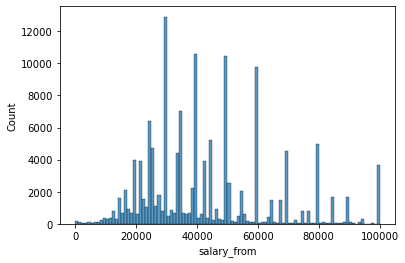

In [70]:
sns.histplot(x='salary_from', data=df.loc[df['salary_from']<=100000])

In [71]:
print('Вакансий с зарплатой менее 1000:', len(df.loc[df['salary_from']<1000]))
df.loc[df['salary_from']<1000].iloc[10:20]

Вакансий с зарплатой менее 1000: 172


,id,name,city,salary_from,salary_to,employer,schedule,published_at,profession_id
17053,42761470,Фельдшер,Екатеринбург,35.0,NaN,ГАПОУ СО Уральский политехнический колледж-МЦК,Полный день,2021-03-03 10:59:09+03:00,25
19326,43277930,Старшая медсестра в стоматологию,Санкт-Петербург,60.0,NaN,MIA Clinic,Полный день,2021-03-23 14:21:18+03:00,52
19977,39337558,Врач-онколог в поликлинику,Пушкино (Московская область),60.0,NaN,ГБУЗ МО Московская Областная Больница Им. Проф...,Полный день,2021-03-13 12:45:11+03:00,54
20479,43119571,Оптометрист,Сергиев Посад,30.0,51.0,Оптика Like,Сменный график,2021-03-17 14:43:52+03:00,56
22089,43393520,Стоматолог универсал,Ростов-на-Дону,35.0,85000.0,Стоматологическая клиника 32 Зуба,Полный день,2021-03-27 12:20:28+03:00,64
22177,43387846,Ассистент стоматолога,Новосибирск,25.0,NaN,Натадент,Сменный график,2021-03-26 18:01:17+03:00,64
22205,43291500,Ассистент врача-стоматолога,Санкт-Петербург,250.0,NaN,Вимастом на Культуре,Полный день,2021-03-26 22:47:46+03:00,64
22673,43344341,Медицинская сестра / ассистент стоматолога,Санкт-Петербург,200.0,250.0,Стоматология Михайловская Клиника,Сменный график,2021-03-25 11:57:35+03:00,64
22954,43277930,Старшая медсестра в стоматологию,Санкт-Петербург,60.0,NaN,MIA Clinic,Полный день,2021-03-23 14:21:18+03:00,64
29624,43185152,Фармацевт/провизор в аптеки дискаунтеры,Новосибирск,40.0,70000.0,Фармаимпекс,Полный день,2021-03-19 12:25:28+03:00,90


In [72]:
# В вакансиях с salary менее 100 умножим на 1000. Что логично.
df.loc[:,'salary_from'] = df['salary_from'].apply(lambda x: x*1000 if x <=100 else x)
df.loc[:,'salary_to'] = df['salary_to'].apply(lambda x: x*1000 if x <=100 else x)

In [73]:
df.loc[df['salary_from']<1000]

,id,name,city,salary_from,salary_to,employer,schedule,published_at,profession_id
6063,43371539,1С программист,Санкт-Петербург,900.0,NaN,Асп-Консалт,Гибкий график,2021-03-26 11:13:47+03:00,396
7455,40544339,Senior/Middle .NET Developer,Екатеринбург,120.0,200000.0,Шарп Девелоперс,Удаленная работа,2021-03-26 09:30:49+03:00,396
10795,43291500,Ассистент врача-стоматолога,Санкт-Петербург,250.0,NaN,Вимастом на Культуре,Полный день,2021-03-26 22:47:46+03:00,2
22205,43291500,Ассистент врача-стоматолога,Санкт-Петербург,250.0,NaN,Вимастом на Культуре,Полный день,2021-03-26 22:47:46+03:00,64
22673,43344341,Медицинская сестра / ассистент стоматолога,Санкт-Петербург,200.0,250.0,Стоматология Михайловская Клиника,Сменный график,2021-03-25 11:57:35+03:00,64
33757,43114475,Системный аналитик,Казань,150.0,250000.0,SSP SOFTWARE,Удаленная работа,2021-03-26 12:58:19+03:00,107
33758,42642854,Системный аналитик,Москва,150.0,250000.0,SSP SOFTWARE,Удаленная работа,2021-03-25 10:00:40+03:00,107
40566,42991789,Senior Product Designer / UI/UX,Москва,200.0,350.0,AppQuantum,Полный день,2021-03-27 13:43:40+03:00,117
48396,41107301,"Software Developer (Java Build Tools, Maven)",Москва,220.0,NaN,JetBrains,Полный день,2021-03-26 12:52:08+03:00,137
60680,43371539,1С программист,Санкт-Петербург,900.0,NaN,Асп-Консалт,Гибкий график,2021-03-26 11:13:47+03:00,167


In [74]:
# Придется это править вручную, а какие-то убирать. Например Няня с зарплатой 250 - указана как часовая.
# В таких вакансиях посчитаем оплату так: в среднем в год 21 день рабочий, 8 часов рабочий день,
# значит имеющуюся сумму умножим на 8 и на 21. Некоторым вакансиям плятят за смему - допустим это за 1 день.
# Некоторых просто дропним.
df.loc[121893,'salary_from'] = 60000
df.loc[122738,'salary_from'] = 60000
df.loc[122216,'salary_to'] = None
df.loc[169756,'salary_from'] = 21250
lst_increase_hour_salary_by_hour = [6063,10795,22205,22673,60680,104780,107730,107741,107885,107906,107931,
                           108229,108525,120643,122216,122667,126631,134418,135293,170070,191774,225071]
lst_increase_hour_salary_by_day = [136183,142534,210436]

lst_drop = [70794,83334,181568,181597,182294,182586,182712,182777]

for i in lst_increase_hour_salary_by_hour:
    if df.loc[i,'salary_from']:
        df.loc[i,'salary_from'] = df.loc[i,'salary_from']*8*21
    if df.loc[i,'salary_to']:
        df.loc[i,'salary_to'] = df.loc[i,'salary_to']*8*21

for i in lst_increase_hour_salary_by_day:
    if df.loc[i,'salary_from']:
        df.loc[i,'salary_from'] = df.loc[i,'salary_from']*8
    if df.loc[i,'salary_to']:
        df.loc[i,'salary_to'] = df.loc[i,'salary_to']*8

df.drop(index=lst_drop, inplace=True)

In [75]:
for i in df.loc[df['salary_from']<1000].index:
    if df.loc[i,'salary_from'] and df.loc[i,'salary_from']<1000:
        df.loc[i,'salary_from'] = df.loc[i,'salary_from']*1000
    if df.loc[i,'salary_to'] and df.loc[i,'salary_to']<1000:
        df.loc[i,'salary_to'] = df.loc[i,'salary_to']*1000

In [76]:
# Сделаем пометку на тип работодателя: гос или не гос.
df.loc[(df['employer'].str.contains('государственн', case=False)) |
                (df['employer'].str.contains('ГБОУ|ГАУЗ|ГБПОУ|ГБУ|ГКБУ|ГКБУК|ГКУ|ГОБУК|ГОУ.{0,3}ВО|ГОУ.{0,3}ВПО|ГУК|КГАУК|КГБНУК|КГБУ|КГКУ|КГУ|МАОУ|МАУ|МБОУ|МБУ|МБУК|МКУ|МУК|НОУ.{0,3}ВПО|ОБУК|ОГАУК|ОГБУК|ОГКУК|ФГАОУ|ФГБВОУ|ФГБНИУ|ФГБНУ|ФГБОУ|ФГБУ|ФГБУК|ФГБУН|ФГКВОУ|ФГКОУ|ФГОУ|ФГУ|ФКУ|ФКУК', case=True)),
                'is_governmental'] = True
df['is_governmental'].fillna(False, inplace=True)

In [77]:
df.loc[(df['salary_from']<10000) & (df['name'].str.contains('стоматолог', case=False))]

,id,name,city,salary_from,salary_to,employer,schedule,published_at,profession_id,is_governmental
14591,41895666,Врач стоматолог-терапевт,Екатеринбург,5400.0,NaN,ГАУЗ СО Областная наркологическая больница,Гибкий график,2021-03-25 05:53:45+03:00,22,True
22073,43320558,Ассистент стоматолога,Москва,4500.0,NaN,Найн Сенс Клиник,Полный день,2021-03-27 15:53:15+03:00,64,False
22096,43393177,Ассистент стоматолога,Москва,4500.0,NaN,Фамильная стоматология,Полный день,2021-03-27 11:18:38+03:00,64,False
22544,43330013,Ассистент стоматолога,Москва,2500.0,NaN,Д.Вита Дент,Полный день,2021-03-24 22:09:29+03:00,64,False
22579,42647228,Ассистент врача-стоматолога,Москва,2550.0,3825.0,Лидер,Полный день,2021-03-25 11:36:41+03:00,64,False
22642,41895666,Врач стоматолог-терапевт,Екатеринбург,5400.0,NaN,ГАУЗ СО Областная наркологическая больница,Гибкий график,2021-03-25 05:53:45+03:00,64,True
22804,42898396,Медицинская сестра в стоматологию,Москва,2500.0,3000.0,Королевство улыбок,Полный день,2021-03-24 19:33:56+03:00,64,False
23059,43213634,Ассистент врача-стоматолога,Москва,3000.0,5000.0,НСД клиник,Полный день,2021-03-21 16:18:04+03:00,64,False
23191,43197183,Ассистент врача-стоматолога,Красногорск,3100.0,NaN,Бизнес Решение,Полный день,2021-03-19 16:58:20+03:00,64,False
23321,43058270,Ассистент стоматолога,Москва,1275.0,2125.0,Стоматологическая клиника АРКУС,Полный день,2021-03-15 20:54:50+03:00,64,False


In [78]:
# Вышеперечисленные ассистенты в не госах содержат в вакансии оплату за смену.
# Смена обычно предполагает несколько раз в неделюЮ будем считать 3 раза в неделю или 12 раз в месяц.
# Многие работодатели не указывают сменный график в Schedule, поэтому просто умножим на 12 это цифру.
for i in df.loc[(df['salary_from']<10000) & (df['name'].str.contains('стоматолог', case=False)) &
               (df['is_governmental'] == False)].index:
    if df.loc[i,'salary_from']:
        df.loc[i,'salary_from'] = df.loc[i,'salary_from']*12
    if df.loc[i,'salary_to']:
        df.loc[i,'salary_to'] = df.loc[i,'salary_to']*12


In [79]:
# Попробуем еще почистить почасовую оплату в ручном режиме.
df.loc[(df['salary_from']<3000) & (df['is_governmental'] == False)]

,id,name,city,salary_from,salary_to,employer,schedule,published_at,profession_id,is_governmental
10917,43389973,Врач Косметолог-эстетист,Екатеринбург,1000.0,102000.0,Персонель косметический салон,Гибкий график,2021-03-26 21:48:19+03:00,2,False
17286,42686436,Фельдшер предрейсового осмотра,Санкт-Петербург,2550.0,25500.0,Вита Мед,Сменный график,2021-03-09 11:34:06+03:00,25,False
20830,43088596,Ветеринарный врач клинической лабораторной диа...,Санкт-Петербург,2000.0,62000.0,Ветеринарная клиника Dr.Pet's,Полный день,2021-03-16 16:16:06+03:00,57,False
28480,43356889,Фармацевт,Выборг,2800.0,NaN,"МАГНИТ, Розничная сеть",Сменный график,2021-03-25 17:21:53+03:00,90,False
57199,43047948,Frontend React Developer (удаленно),Саратов,1000.0,1500.0,ИнфоБиС,Удаленная работа,2021-03-15 15:22:21+03:00,157,False
...,...,...,...,...,...,...,...,...,...,...
225260,42726380,Горничная в отель,Москва,1400.0,2800.0,Максима Хотелс,Полный день,2021-03-26 10:35:44+03:00,905,False
225548,42843979,Горничная,Москва,2000.0,50000.0,Shelter-Hotels,Полный день,2021-03-05 20:34:35+03:00,905,False
226555,42731680,Горничная,Краснодар,1275.0,NaN,Royal,Полный день,2021-03-02 12:14:43+03:00,905,False
227345,42834889,Уборщик(ца),Пушкино (Московская область),2000.0,NaN,OPTIPART,Полный день,2021-03-25 16:07:13+03:00,906,False


In [80]:
df.loc[57199,'salary_from'] = df.loc[57199,'salary_from']*8*21
df.loc[57199,'salary_to'] = df.loc[57199,'salary_to']*8*21
df.loc[141722,'salary_from'] = df.loc[57199,'salary_from']*21
df.loc[152596,'salary_from'] = 100000
df.loc[160518,'salary_from'] = 100000
df.loc[166906,'salary_from'] = 40000
df.loc[168016,'salary_from'] = 40000
df.loc[168097,'salary_from'] = 55000
df.loc[174514,'salary_from'] = df.loc[57199,'salary_from']*4
df.loc[174514,'salary_to'] = df.loc[57199,'salary_to']*4
df.loc[178917,'salary_from'] = df.loc[57199,'salary_from']*4
df.loc[178917,'salary_to'] = df.loc[57199,'salary_to']*4

lst_increase_hour_salary_by_day = [97647,98484,99694,99889,99923,107746,107760,107782,107793,
                                  107818,108058,108069,108207,123750,124494,124898,134834,134982,
                                  135817,136011,136199,136257,136376,137278,137492,137929,
                                  139786,141055,141232,141386,141413,141675,141814,141931,142472,
                                  142755,142866,143002,143100,143133,143243,143261,143459,143572,
                                  143581,143619,148333,148498,148566,150315,159364,165638,166284,
                                  166433,166540,166605,166606,166677,166690,166800,166829,166980,
                                  167062,167101,167255,167314,167378,167787,167899,167900,168282,
                                  168313,169815,170515,176970]
for i in lst_increase_hour_salary_by_day:
    if df.loc[i,'salary_from']:
        df.loc[i,'salary_from'] = df.loc[i,'salary_from']*8
    if df.loc[i,'salary_to']:
        df.loc[i,'salary_to'] = df.loc[i,'salary_to']*8

In [81]:
df.loc[df['salary_from']<10000]

,id,name,city,salary_from,salary_to,employer,schedule,published_at,profession_id,is_governmental
662,42226689,Менеджер по продажам страховых продуктов (г. С...,Серебряные Пруды,8730.0,51000.0,Росгосстрах,Гибкий график,2021-03-25 10:52:12+03:00,381,False
695,42226851,Менеджер по продажам страховых продуктов (г. М...,Можайск,8730.0,51000.0,Росгосстрах,Гибкий график,2021-03-25 10:52:22+03:00,381,False
696,42223928,Менеджер по продажам страховых продуктов (г. Ф...,Фряново,8730.0,51000.0,Росгосстрах,Гибкий график,2021-03-25 09:52:27+03:00,381,False
702,42227112,Менеджер по продажам страховых продуктов (г. З...,Зарайск,8730.0,51000.0,Росгосстрах,Гибкий график,2021-03-25 10:52:36+03:00,381,False
703,42226702,Менеджер по продажам страховых продуктов (г. Р...,Руза,8730.0,51000.0,Росгосстрах,Гибкий график,2021-03-25 10:52:14+03:00,381,False
...,...,...,...,...,...,...,...,...,...,...
228520,43176236,Дежурная-уборщица/Дежурный-уборщик,Красноярск,6000.0,8000.0,Учебно-производственный центр Инопроф,Сменный график,2021-03-19 09:13:59+03:00,906,False
228532,42033697,Уборщица/Уборщик (г. Жирновск),Жирновск,3400.0,NaN,«Сеть салонов «Мир оптики»,Полный день,2021-03-22 09:16:02+03:00,906,False
228533,43135524,Вечерний уборщик офисных помещений,Томск,7000.0,NaN,Медиа-холдинг Рекламный Дайджест,Гибкий график,2021-03-18 05:23:29+03:00,906,False
228559,43184874,Уборщик / Уборщица (Щербинка),Щербинка,6000.0,NaN,Улыбка радуги,Полный день,2021-03-19 12:17:59+03:00,906,False


Посчитаем для всех вакансий недостающие salary_to и salary_from если известна хотя бы одна из них:
допустим если у вакансии не указана salary_to, то определим для каждой вакансии среднюю процентную разницу з/п по профессии, если на профессию менее 30 вакансий, то средний прирост по всем вакансиям.

In [82]:
df_salary_mean = df[(~df['salary_to'].isnull()) & (~df['salary_from'].isnull())].groupby('profession_id')[['salary_from','salary_to']].mean()
df_salary_count = df[(~df['salary_to'].isnull()) & (~df['salary_from'].isnull())].groupby('profession_id')[['id']].count()
df_salary_count = df_salary_count[df_salary_count['id']>=30]
df_salary_count.reset_index(inplace=True)
df_salary_mean.reset_index(inplace=True)
df_salary_mean.head()

,profession_id,salary_from,salary_to
0,1,52650.00000,103078.571429
1,2,47891.60969,81098.896366
2,3,60000.00000,90000.000000
3,5,58531.25000,124781.250000
4,8,43875.00000,61583.333333


In [83]:
df_salary_count.head()

,profession_id,id
0,2,743
1,11,71
2,18,65
3,20,86
4,22,670


In [84]:
df_salary_mean.loc[:,'diff'] = round(1-df_salary_mean['salary_from']/df_salary_mean['salary_to'],2)
df_salary_mean.head()                           

,profession_id,salary_from,salary_to,diff
0,1,52650.00000,103078.571429,0.49
1,2,47891.60969,81098.896366,0.41
2,3,60000.00000,90000.000000,0.33
3,5,58531.25000,124781.250000,0.53
4,8,43875.00000,61583.333333,0.29


In [85]:
df_salary_count.head()

,profession_id,id
0,2,743
1,11,71
2,18,65
3,20,86
4,22,670


In [86]:
df_salary_mean = df_salary_mean.merge(df_salary_count, how='inner', left_on='profession_id', right_on='profession_id')
df_salary_mean.drop(columns=['salary_from','salary_to','id'], inplace=True)
df_salary_mean.head()

,profession_id,diff
0,2,0.41
1,11,0.31
2,18,0.45
3,20,0.36
4,22,0.44


In [87]:
salary_diff_mean = df_salary_mean['diff'].mean()
salary_diff_mean

0.3277199999999999

In [88]:
def salary_to(data):
    if data[0]>0 and data[1]>0:
        return pd.Series([data[0],data[1]])
    
    if np.isnan(data[0]) and np.isnan(data[1]):
        return pd.Series([0,0])
    
    if data[0]>0 and np.isnan(data[1]):
        diff = df_salary_mean.loc[df_salary_mean['profession_id']==data[2],'diff']
        if len(diff) > 0:
            diff = diff.iloc[0]
        else:
            diff = salary_diff_mean
        return pd.Series([data[0],data[0]/(1-diff)])
    
    if np.isnan(data[0]) and data[1]>0:
        diff = df_salary_mean.loc[df_salary_mean['profession_id']==data[2],'diff']
        if len(diff) > 0:
            diff = diff.iloc[0]
        else:
            diff = salary_diff_mean
        return pd.Series([data[1]*(1-diff),data[1]])
    
    return pd.Series([1,1])

tqdm.pandas(desc="Дополняем суммы")
df[['salary_from','salary_to']] = df[['salary_from','salary_to','profession_id']].progress_apply(salary_to, axis=1)

Дополняем суммы: 100%|██████████| 231727/231727 [01:13<00:00, 3151.17it/s]


In [89]:
df[['salary_from','salary_to']] = df[['salary_from','salary_to']].round(0)
df.head()

,id,name,city,salary_from,salary_to,employer,schedule,published_at,profession_id,is_governmental
0,43107516,IT director,Москва,300000.0,500000.0,Представительство МКК ТРИДЕР ФАЙНЭНШЕЛ КОРП.,Полный день,2021-03-26 10:48:48+03:00,380,False
1,42809210,IT директор,Санкт-Петербург,120000.0,150000.0,Сеть грузинских ресторанов Пхали Хинкали,Полный день,2021-03-25 15:17:07+03:00,380,False
2,43336018,Руководитель IT-отдела / IT директор,Санкт-Петербург,0.0,0.0,Вальд,Полный день,2021-03-25 08:54:53+03:00,380,False
3,43251658,IT директор,Москва,0.0,0.0,Урал Логистика,Полный день,2021-03-25 17:59:15+03:00,380,False
4,43322148,ИТ-директор/CTO,Москва,300000.0,446243.0,Qip.ru,Полный день,2021-03-24 16:29:24+03:00,380,False


In [125]:
df.to_pickle('df_after_salary_chenges.pcl')

## Сбор и обработка детализированных данных.

In [91]:
all_files = glob.glob('old/df_detailed*.csv')

li = []

for filename in all_files:
    df_detailed_part = pd.read_csv(filename, low_memory=False)
    li.append(df_detailed_part)

df_detailed_old = pd.concat(li, axis=0, ignore_index=True)
df_detailed_old.drop(columns='Unnamed: 0', inplace=True)

In [92]:
all_files = glob.glob('df_detailed*.csv')

li = []

for filename in all_files:
    df_detailed_part = pd.read_csv(filename, low_memory=False)
    li.append(df_detailed_part)

df_detailed = pd.concat(li, axis=0, ignore_index=True)
df_detailed.drop(columns='Unnamed: 0', inplace=True)

In [93]:
df_detailed = pd.concat([df_detailed,df_detailed_old])

In [94]:
print('Всего найдено уникальных вакансий:', len(df_detailed['id'].unique()))
print('shape:',df_detailed.shape)
df_detailed.head()

Всего найдено уникальных вакансий: 263485
shape: (263485, 45)


,id,premium,billing_type,relations,name,insider_interview,response_letter_required,area,salary,type,...,negotiations_url,suitable_resumes_url,apply_alternate_url,has_test,test,alternate_url,working_days,working_time_intervals,working_time_modes,accept_temporary
0,43107516,False,"{'id': 'standard_plus', 'name': 'Стандарт плюс'}",[],IT director,NaN,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 300000, 'to': 500000, 'currency': 'RU...","{'id': 'open', 'name': 'Открытая'}",...,NaN,NaN,https://hh.ru/applicant/vacancy_response?vacan...,False,NaN,https://hh.ru/vacancy/43107516,[],[],[],False
1,43336018,False,"{'id': 'standard_plus', 'name': 'Стандарт плюс'}",[],Руководитель IT-отдела / IT директор,NaN,False,"{'id': '2', 'name': 'Санкт-Петербург', 'url': ...",NaN,"{'id': 'open', 'name': 'Открытая'}",...,NaN,NaN,https://hh.ru/applicant/vacancy_response?vacan...,False,NaN,https://hh.ru/vacancy/43336018,[],[],[],False
2,43251658,False,"{'id': 'standard_plus', 'name': 'Стандарт плюс'}",[],IT директор,NaN,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",NaN,"{'id': 'open', 'name': 'Открытая'}",...,NaN,NaN,https://hh.ru/applicant/vacancy_response?vacan...,False,NaN,https://hh.ru/vacancy/43251658,[],[],[],False
3,43322148,True,"{'id': 'premium', 'name': 'Премиум'}",[],ИТ-директор/CTO,NaN,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 300000, 'to': None, 'currency': 'RUR'...","{'id': 'open', 'name': 'Открытая'}",...,NaN,NaN,https://hh.ru/applicant/vacancy_response?vacan...,False,NaN,https://hh.ru/vacancy/43322148,[],[],[],False
4,43348110,False,"{'id': 'standard', 'name': 'Стандарт'}",[],Директор по IT,NaN,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",NaN,"{'id': 'open', 'name': 'Открытая'}",...,NaN,NaN,https://hh.ru/applicant/vacancy_response?vacan...,False,NaN,https://hh.ru/vacancy/43348110,[],[],[],False


In [6]:
#df_detailed.to_pickle('df_detailed_full.pcl')
df_detailed = pd.read_pickle('df_detailed_full.pcl')

In [43]:
display(df_detailed['accept_kids'].unique())
df_detailed['accept_kids'].value_counts()

array([False,  True])

False    263226
True        259
Name: accept_kids, dtype: int64

In [44]:
display(df_detailed['schedule'].unique())
df_detailed['schedule'].value_counts()

array(["{'id': 'fullDay', 'name': 'Полный день'}",
       "{'id': 'remote', 'name': 'Удаленная работа'}",
       "{'id': 'flexible', 'name': 'Гибкий график'}",
       "{'id': 'shift', 'name': 'Сменный график'}",
       "{'id': 'flyInFlyOut', 'name': 'Вахтовый метод'}"], dtype=object)

{'id': 'fullDay', 'name': 'Полный день'}           192221
{'id': 'shift', 'name': 'Сменный график'}           28689
{'id': 'remote', 'name': 'Удаленная работа'}        20077
{'id': 'flexible', 'name': 'Гибкий график'}         13772
{'id': 'flyInFlyOut', 'name': 'Вахтовый метод'}      8726
Name: schedule, dtype: int64

Режим работы в вакансиях может быть указан только 1.

Есть вакансии для детей. Добавим это в отдельную таблицу, чтобы заново все не загружать и не возиться с основными датафреймами.

In [60]:
df_kids = df_detailed[['id','accept_kids']].copy()
df_kids.head(2)

,id,accept_kids
0,43107516,False
1,43336018,False


In [61]:
df_kids.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263485 entries, 0 to 198966
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   id           263485 non-null  int64
 1   accept_kids  263485 non-null  bool 
dtypes: bool(1), int64(1)
memory usage: 12.3 MB


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 231735 entries, 0 to 231734
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype                                
---  ------         --------------   -----                                
 0   id             231735 non-null  object                               
 1   name           231735 non-null  object                               
 2   city           231735 non-null  object                               
 3   salary_from    148170 non-null  float64                              
 4   salary_to      88089 non-null   float64                              
 5   employer       231735 non-null  object                               
 6   schedule       231735 non-null  object                               
 7   published_at   231735 non-null  datetime64[ns, pytz.FixedOffset(180)]
 8   profession_id  231735 non-null  int64                                
dtypes: datetime64[ns, pytz.FixedOffset(180)](1), float64(2), int

In [63]:
tmpdf = df.rename(columns={'id': 'vacancy_id'}).drop_duplicates(subset=['vacancy_id'], keep='first').copy()
tmpdf.loc[:,'vacancy_id'] = pd.to_numeric(tmpdf['vacancy_id'], downcast='integer')

In [64]:
df_kids = df_kids[df_kids['id'].isin(tmpdf['vacancy_id'].unique())]
df_kids.rename(columns={'id': 'vacancy_id'}, inplace=True)
df_kids.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201555 entries, 0 to 198965
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   vacancy_id   201555 non-null  int64
 1   accept_kids  201555 non-null  bool 
dtypes: bool(1), int64(1)
memory usage: 3.3 MB


In [69]:
df_kids.reset_index(drop=True, inplace=True)

In [70]:
# Загружаем их в БД.
conn = connect(param_dic)
execute_mogrify_insert(conn, df_kids.loc[0:49999], 'kids')
execute_mogrify_insert(conn, df_kids.loc[50000:99999], 'kids')
execute_mogrify_insert(conn, df_kids.loc[100000:149999], 'kids')
execute_mogrify_insert(conn, df_kids.loc[150000:], 'kids')
conn.close()

Connection successful
execute_mogrify() done
execute_mogrify() done
execute_mogrify() done
execute_mogrify() done


In [95]:
# id -> vacancy_id как в БД.
df.rename(columns={'id': 'vacancy_id'}, inplace=True)

"""# Произведём поиск вакансий в БД, мало ли они уже есть.
# Если есть, то отметим вакансию как update, если нет - insert.
conn = connect(param_dic)
df['vac_db_status'] = df['vacancy_id'].apply(execute_mogrify_search_vacancy, conn=conn)

# Те вакансии, которые должны быть обновлены - обновим, изменив в них поле published_at.
df_update = df[df['vac_db_status'] == 'update'].drop_duplicates(subset=['vacancy_id'], keep='first')
df_update[['vacancy_id', 'published_at']].apply(execute_mogrify_update_vacancy, axis=1, conn=conn)
conn.close()

# Оставим только те вакансии, которые необходимо добавить в БД.
df = df[df['vac_db_status'] == 'insert']"""

# Т.к. одна вакансия может соответствовать нескольким профессиям,
# то одну таблицу для БД необходимо подготовить сейчас.
df_key_professions = df[['vacancy_id', 'profession_id']]

# Уберём дубликаты.
df.drop_duplicates(subset=['vacancy_id'], keep='first', inplace=True, ignore_index=True)

In [96]:
df_detailed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263485 entries, 0 to 198966
Data columns (total 45 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   id                            263485 non-null  int64  
 1   premium                       263485 non-null  bool   
 2   billing_type                  263485 non-null  object 
 3   relations                     263485 non-null  object 
 4   name                          263485 non-null  object 
 5   insider_interview             1168 non-null    object 
 6   response_letter_required      263485 non-null  bool   
 7   area                          263485 non-null  object 
 8   salary                        183772 non-null  object 
 9   type                          263485 non-null  object 
 10  address                       148184 non-null  object 
 11  allow_messages                263485 non-null  bool   
 12  site                          263485 non-nul

Несколько заметок:
1. Только в половине вакансий указывается адрес.
2. 13% вакансий используют брендированное описание.
3. 0,4% вакансий используют интервью о жизни в компании.
4. 1,2% вакансий включают в себя тестирование на hh.ru.
5. 68% вакансий содержат вилку оклада.

Да, можно ещё поизучать данные эти данные, но цель проекта не в этом. Поэтому я двигаюсь дальше.

In [126]:
# Оставляем только нужные колонки.
df_detailed = df_detailed[['id', 'experience', 'description', 'created_at', 'key_skills', 'specializations']]

In [127]:
# Убираем HTML символы из описания к вакансиям.
df_detailed.loc[:, 'description'] = df_detailed['description'].apply(lambda x: re.sub(r'\<[^>]*\>', ' ', x) if x else x)
df_detailed.loc[:, 'description'] = df_detailed['description'].apply(lambda x: re.sub('&quot', ' ', x) if x else x)
df_detailed.loc[:, 'description'] = df_detailed['description'].apply(lambda x: re.sub(r'\s{2,}', ' ', x) if x else x)

In [128]:
# Дополним основной массив детализированными данными.
df.loc[:,'vacancy_id'] = pd.to_numeric(df['vacancy_id'], downcast='integer')
df_detailed.loc[:,'id'] = pd.to_numeric(df_detailed['id'], downcast='integer')
df = df.merge(df_detailed, how='left', left_on='vacancy_id', right_on='id')

In [129]:
# Получим детализированную информацию по каждой вакансии.
# Нужно загрузки 198500 вакансий. С таймером в 0.3 сек между запросами это примерно 10800 вакансий в час.
#tqdm.pandas(desc="Загружаем детализированную информацию по каждой вакансии.")
#df[['experience', 'description', 'created_at', 'key_skills', 'specializations']] = df['vacancy_id'].progress_apply(get_vacancy_detailed)

# Изменим тип данных в колонке на datetime.
df.loc[:,'created_at'] = pd.to_datetime(df['created_at'], format='%Y-%m-%d %H:%M:%S')

In [130]:
# Готовим датафреймы к загрузке в БД.
df_vacancies = df[['vacancy_id', 'name', 'city', 'salary_from', 'salary_to', 'employer', 'schedule', 'experience', 'description', 'created_at', 'published_at']].copy()
df_vacancies.loc[:,'description'] = df_vacancies['description'].str.replace(']', ')', regex=False)
df_vacancies.loc[:,'description'] = df_vacancies['description'].str.replace('[', '(', regex=False)
df_vacancies.loc[:,'description'] = df_vacancies['description'].str.replace('%', ' проц.', regex=False)
df_vacancies.loc[:,'name'] = df_vacancies['name'].str.replace('%', ' проц.', regex=False)
df_vacancies.loc[:,'name'] = df_vacancies['name'].str.replace(']', '', regex=False)
df_vacancies.loc[:,'name'] = df_vacancies['name'].str.replace('[', '', regex=False)
df_vacancies.loc[:,'employer'] = df_vacancies['employer'].str.replace('%', ' проц.', regex=False)
df_vacancies.loc[:,'employer'] = df_vacancies['employer'].str.replace(']', ')', regex=False)
df_vacancies.loc[:,'employer'] = df_vacancies['employer'].str.replace('[', '(', regex=False)
df_vacancies.loc[:,'experience'] = df_vacancies['experience'].apply(lambda x: ast.literal_eval(x) if type(x) == str else None)
df_vacancies.loc[:,'experience'] = df_vacancies['experience'].apply(lambda x: x['name'] if x else x)
df_vacancies.loc[df_vacancies['created_at'].isnull(),['created_at']] = df_vacancies['published_at']

In [ ]:
df_key_skills = df[['vacancy_id', 'key_skills']].copy()
df_key_skills.loc[:,'key_skills'] = df_key_skills['key_skills'].apply(lambda x: ast.literal_eval(x) if type(x) == str else None)
df_key_skills.dropna(inplace=True)
df_key_skills = pd.DataFrame([i for i in df_key_skills['key_skills']], index=df_key_skills['vacancy_id']).stack()
df_key_skills = df_key_skills.reset_index()[[0, 'vacancy_id']]
df_key_skills.columns = ['key_skills', 'vacancy_id']
df_key_skills.loc[:,'key_skills'] = df_key_skills['key_skills'].apply(lambda x: x['name'])
df_key_skills = df_key_skills[['vacancy_id', 'key_skills']]
df_key_skills.rename(columns={'key_skills': 'name'}, inplace=True)
df_key_skills.loc[:,'name'] = df_key_skills['name'].apply(lambda x: x.replace('%',' проц.') if type(x) == str else x)

In [ ]:
df_key_specializations = df[['vacancy_id', 'specializations']].copy()
df_key_specializations.loc[:,'specializations'] = df_key_specializations['specializations'].apply(lambda x: ast.literal_eval(x) if type(x) == str else None)
df_key_specializations.dropna(inplace=True)
df_key_specializations = pd.DataFrame([i for i in df_key_specializations['specializations']], index=df_key_specializations['vacancy_id']).stack()
df_key_specializations = df_key_specializations.reset_index()[[0, 'vacancy_id']]
df_key_specializations.columns = ['specializations', 'vacancy_id']
df_key_specializations.loc[:,'specializations'] = df_key_specializations['specializations'].apply(lambda x: x['id'])
df_key_specializations = df_key_specializations[['vacancy_id', 'specializations']]
df_key_specializations.rename(columns={'specializations': 'spec_id'}, inplace=True)

In [133]:
df_vacancies.loc[(df_vacancies['name'].str.contains('заместитель|руководитель|директор|начальник|director|CAE|CAO|CBO|CBDO|CCO|CEO|CDO|CFO|CHRO|CIO|CKO|CLO|СМО|CPO|CQO|CRO|CRMO|CSO|CSPO|CTL|OFS|STL|SVP|COO|CLO', case=False)) &
                 (~df_vacancies['name'].str.contains('помощник|продавец|пристав|переводчик|торговый представитель|мерчендайзер|Инженер-программист|Web-аналитик|Продуктовый аналитик', case=False)),
                 'level_chief'] = True
df_vacancies['level_chief'].fillna(False, inplace=True)

In [134]:
df_vacancies.loc[(df_vacancies['name'].str.contains('senior|сеньор|ведущий|lead', case=False)) |
                  (df_vacancies['description'].str.contains('senior|сеньор|lead', case=False, na=False)),
                  'level_senior'] = True
df_vacancies['level_senior'].fillna(False, inplace=True)

In [135]:
df_vacancies.loc[(df_vacancies['name'].str.contains('миддл|middle', case=False)) |
                  (df_vacancies['description'].str.contains('миддл|middle', case=False, na=False)),
                  'level_middle'] = True
df_vacancies.loc[(df_vacancies['level_chief']),'level_middle'] = False                  
df_vacancies['level_middle'].fillna(False, inplace=True)

In [136]:
df_vacancies.loc[(df_vacancies['name'].str.contains('младший|junior|помощник|ассистент', case=False)) | 
                 (df_vacancies['description'].str.contains('младший|junior|помощник|ассистент', case=False, na=False)),
                 'level_junior'] = True
df_vacancies.loc[(df_vacancies['level_senior']),'level_junior'] = False
df_vacancies['level_junior'].fillna(False, inplace=True)

In [137]:
df_vacancies.loc[((df_vacancies['name'].str.contains('интерн|intern|стаж[её]р', case=False)) & (~df_vacancies['name'].str.contains('интернет|internet|international', case=False))) | 
                 ((df_vacancies['description'].str.contains('интерн|intern|стаж[её]р', case=False, na=False)) & (~df_vacancies['description'].str.contains('интернет|internet|international', case=False, na=False)))
                 ,'level_intern'] = True
df_vacancies.loc[(df_vacancies['level_chief']),'level_intern'] = False
df_vacancies.loc[(df_vacancies['level_senior']),'level_intern'] = False
df_vacancies.loc[(df_vacancies['level_middle']),'level_intern'] = False
df_vacancies['level_intern'].fillna(False, inplace=True)

In [138]:
# Сделаем пометку на тип работодателя: гос или не гос.
df_vacancies.loc[(df_vacancies['employer'].str.contains('государственн', case=False)) |
                (df_vacancies['employer'].str.contains('ГБОУ|МФЦ|ГАУЗ|ГБПОУ|ГБУ|ГКБУ|ГКБУК|ГКУ|ГОБУК|ГОУ.{0,3}ВО|ГОУ.{0,3}ВПО|ГУК|КГАУК|КГБНУК|КГБУ|КГКУ|КГУ|МАОУ|МАУ|МБОУ|МБУ|МБУК|МКУ|МУК|НОУ.{0,3}ВПО|ОБУК|ОГАУК|ОГБУК|ОГКУК|ФГАОУ|ФГБВОУ|ФГБНИУ|ФГБНУ|ФГБОУ|ФГБУ|ФГБУК|ФГБУН|ФГКВОУ|ФГКОУ|ФГОУ|ФГУ|ФКУ|ФКУК', case=True)),
                'is_governmental'] = True
df_vacancies['is_governmental'].fillna(False, inplace=True)

In [139]:
df_vacancies.rename(columns={'city':'city_id'}, inplace=True)

In [140]:
temp = df_vacancies.copy()

In [141]:
df_vacancies.loc[df_vacancies['city_id'].isnull()]

,vacancy_id,name,city_id,salary_from,salary_to,employer,schedule,experience,description,created_at,published_at,level_chief,level_senior,level_middle,level_junior,level_intern,is_governmental
72122,42632210,Специалист по закупкам (indirect),NaN,0.0,0.0,Kelly Services,Полный день,None,NaN,2021-03-26 00:24:31+03:00,2021-03-26 00:24:31+03:00,False,False,False,False,False,False
72337,42632211,Менеджер по закупкам технологического оборудов...,NaN,0.0,0.0,Kelly Services,Полный день,None,NaN,2021-03-26 00:24:31+03:00,2021-03-26 00:24:31+03:00,False,False,False,False,False,False
126650,42628558,Юрист,NaN,0.0,0.0,Kelly Services,Удаленная работа,None,NaN,2021-03-26 00:24:24+03:00,2021-03-26 00:24:24+03:00,False,False,False,False,False,False
127196,42632207,Младший Юрист,NaN,0.0,0.0,Kelly Services,Полный день,None,NaN,2021-03-26 00:24:29+03:00,2021-03-26 00:24:29+03:00,False,False,False,True,False,False
189600,42612386,Секретарь,NaN,30983.0,38250.0,Kelly Services,Полный день,None,NaN,2021-03-26 00:24:18+03:00,2021-03-26 00:24:18+03:00,False,False,False,False,False,False


In [142]:
df_vacancies.loc[df_vacancies['city_id'].isnull(), 'city_id'] = 0
df_vacancies['city_id'] = df_vacancies['city_id'].apply(int)

In [144]:
df_vacancies.head(2)

,vacancy_id,name,city_id,salary_from,salary_to,employer,schedule,experience,description,created_at,published_at,level_chief,level_senior,level_middle,level_junior,level_intern,is_governmental
0,43107516,IT director,1,300000.0,500000.0,Представительство МКК ТРИДЕР ФАЙНЭНШЕЛ КОРП.,Полный день,От 1 года до 3 лет,We are looking for a key top manager for our ...,2021-03-26 10:48:48+03:00,2021-03-26 10:48:48+03:00,True,True,False,False,False,False
1,42809210,IT директор,2,120000.0,150000.0,Сеть грузинских ресторанов Пхали Хинкали,Полный день,От 3 до 6 лет,Мы - растущая компания в сегменте HoReCa. Мы ...,2021-03-19 15:17:07+03:00,2021-03-25 15:17:07+03:00,True,False,False,False,False,False


In [145]:
df_key_professions.head(2)

,vacancy_id,profession_id
0,43107516,380
1,42809210,380


In [146]:
df_key_skills.head(2)

,vacancy_id,name
0,43107516,Negotiation skills
1,43107516,Linux


In [147]:
df_key_specializations.head(2)

,vacancy_id,spec_id
0,43107516,9.94
1,42809210,1.221


In [321]:
df_vacancies.to_pickle('df_vacancies_before_SQL_load.pcl')
df_key_professions.to_pickle('df_key_professions_before_SQL_load.pcl')
df_key_skills.to_pickle('df_key_skills_before_SQL_load.pcl')
df_key_specializations.to_pickle('df_key_specializations_before_SQL_load.pcl')

In [5]:
# Загружаем их в БД.
conn = connect(param_dic)
execute_mogrify_insert(conn, df_vacancies.loc[0:49999], 'vacancies')
execute_mogrify_insert(conn, df_vacancies.loc[50000:99999], 'vacancies')
execute_mogrify_insert(conn, df_vacancies.loc[100000:149999], 'vacancies')
execute_mogrify_insert(conn, df_vacancies.loc[150000:], 'vacancies')
execute_mogrify_insert(conn, df_key_professions, 'key_professions')
execute_mogrify_insert(conn, df_key_skills, 'key_skills')
execute_mogrify_insert(conn, df_key_specializations, 'key_specializations')
conn.close()

Connection successful
execute_mogrify() done
execute_mogrify() done
execute_mogrify() done
execute_mogrify() done
